In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os


In [2]:
# Load data
def load_data(base_dir):
    def load_csv(file_name):
        return pd.read_csv(os.path.join(base_dir, file_name))
    
    df_orders = load_csv('orders.csv')
    df_order_items = load_csv('order_items.csv')
    df_products = load_csv('products.csv')
    df_distribution_centers = load_csv('distribution_centers.csv')
    df_users = load_csv('users.csv')
    
    return df_orders, df_order_items, df_products, df_distribution_centers, df_users

In [3]:
# Data Transformation for Sales Performance
def transform_data(df_orders, df_order_items, df_products):
    # Merge data
    orders_merged = pd.merge(df_order_items, df_products, left_on='product_id', right_on='id', how='left')
    orders_merged = pd.merge(orders_merged, df_orders, left_on='order_id', right_on='order_id', how='left')
    
    # Calculate profit
    orders_merged['profit'] = orders_merged['sale_price'] - orders_merged['cost']
    
    # Handle missing values
    orders_merged['sale_price'].fillna(orders_merged['sale_price'].median(), inplace=True)
    
    # Rename columns to remove suffixes
    orders_merged.rename(columns={
        'created_at_x': 'created_at', 
        'shipped_at_x': 'shipped_at', 
        'delivered_at_x': 'delivered_at', 
        'returned_at_x': 'returned_at', 
        'status_x': 'status'}, inplace=True)
    
    # Print columns to debug
    print("Columns in orders_merged:", orders_merged.columns)
    
    # Format date columns
    date_columns = ['created_at', 'shipped_at', 'delivered_at', 'returned_at']
    missing_columns = [col for col in date_columns if col not in orders_merged.columns]
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
        date_columns = [col for col in date_columns if col in orders_merged.columns]
    
    for col in date_columns:
        orders_merged[col] = pd.to_datetime(orders_merged[col], errors='coerce')
    
    # Filter completed orders
    orders_complete = orders_merged[orders_merged['status'] == 'Complete'].copy()
    
    return orders_complete

In [4]:
# Analyze Sales Performance
def analyze_sales_performance(orders_complete):
    # Sales trends over time
    orders_complete['year_month'] = orders_complete['created_at'].dt.to_period('M')
    sales_trends = orders_complete.groupby('year_month')['sale_price'].sum().reset_index()
    
    # Check data types
    print(sales_trends.dtypes)
    
    # Convert year_month to string for plotting
    sales_trends['year_month'] = sales_trends['year_month'].astype(str)
    
    # Top-selling products
    top_products = orders_complete.groupby('product_id')['sale_price'].sum().sort_values(ascending=False).head(10).reset_index()
    
    # Sales by distribution center
    sales_by_dc = orders_complete.groupby('distribution_center_id')['sale_price'].sum().reset_index()
    
    # Visualizations
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=sales_trends, x='year_month', y='sale_price')
    plt.title('Sales Trends Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.show()
    
    plt.figure(figsize=(14, 7))
    sns.barplot(data=top_products, x='product_id', y='sale_price')
    plt.title('Top-Selling Products')
    plt.xlabel('Product ID')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.show()
    
    plt.figure(figsize=(14, 7))
    sns.barplot(data=sales_by_dc, x='distribution_center_id', y='sale_price')
    plt.title('Sales by Distribution Center')
    plt.xlabel('Distribution Center ID')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45)
    plt.show()

In [5]:
# Customer Segmentation
def customer_segmentation(df_orders, df_order_items, df_users):
    # Inspect DataFrames before merging
    print("Columns in df_orders:", df_orders.columns)
    print("Columns in df_order_items:", df_order_items.columns)
    print("Columns in df_users:", df_users.columns)
    
    # Merge orders and order items to get sale_price
    orders_items_merged = pd.merge(df_orders, df_order_items, left_on='order_id', right_on='order_id', how='left')
    
    # Print columns to debug
    print("Columns in orders_items_merged:", orders_items_merged.columns)
    
    # Merge with users data using the correct key columns
    orders_users = pd.merge(orders_items_merged, df_users, left_on='user_id_x', right_on='id', how='left')
    
    # Print columns to debug
    print("Columns in orders_users:", orders_users.columns)
    
    # Aggregate customer data
    customer_data = orders_users.groupby('user_id_x').agg({
        'sale_price': ['sum', 'mean', 'count'],
        'created_at_x': ['max', 'min']
    }).reset_index()
    customer_data.columns = ['user_id', 'total_spent', 'avg_order_value', 'order_count', 'last_order_date', 'first_order_date']
    
    # Convert date columns to datetime and remove timezone information
    customer_data['last_order_date'] = pd.to_datetime(customer_data['last_order_date']).dt.tz_localize(None)
    customer_data['first_order_date'] = pd.to_datetime(customer_data['first_order_date']).dt.tz_localize(None)
    
    # Calculate recency and frequency
    customer_data['recency'] = (pd.to_datetime('today') - customer_data['last_order_date']).dt.days
    customer_data['frequency'] = customer_data['order_count']
    
    # Merge with demographic data
    customer_data = pd.merge(customer_data, df_users, left_on='user_id', right_on='id', how='left')
    
    # Select relevant features for clustering
    features = ['total_spent', 'avg_order_value', 'recency', 'frequency', 'age']
    customer_data = customer_data[features].dropna()
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(customer_data)
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    customer_data['segment'] = kmeans.fit_predict(scaled_features)
    
    # Visualizations
    sns.pairplot(customer_data, hue='segment', palette='Set2')
    plt.show()
    
    avg_spending = customer_data.groupby('segment')['total_spent'].mean().reset_index()
    plt.figure(figsize=(14, 7))
    sns.barplot(data=avg_spending, x='segment', y='total_spent')
    plt.title('Average Spending by Customer Segment')
    plt.xlabel('Segment')
    plt.ylabel('Average Spending')
    plt.show()

Columns in orders_merged: Index(['id_x', 'order_id', 'user_id_x', 'product_id', 'inventory_item_id',
       'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price', 'id_y', 'cost', 'category', 'name', 'brand',
       'retail_price', 'department', 'sku', 'distribution_center_id',
       'user_id_y', 'status_y', 'gender', 'created_at_y', 'returned_at_y',
       'shipped_at_y', 'delivered_at_y', 'num_of_item', 'profit'],
      dtype='object')


c:\Users\Hande\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


year_month    period[M]
sale_price      float64
dtype: object


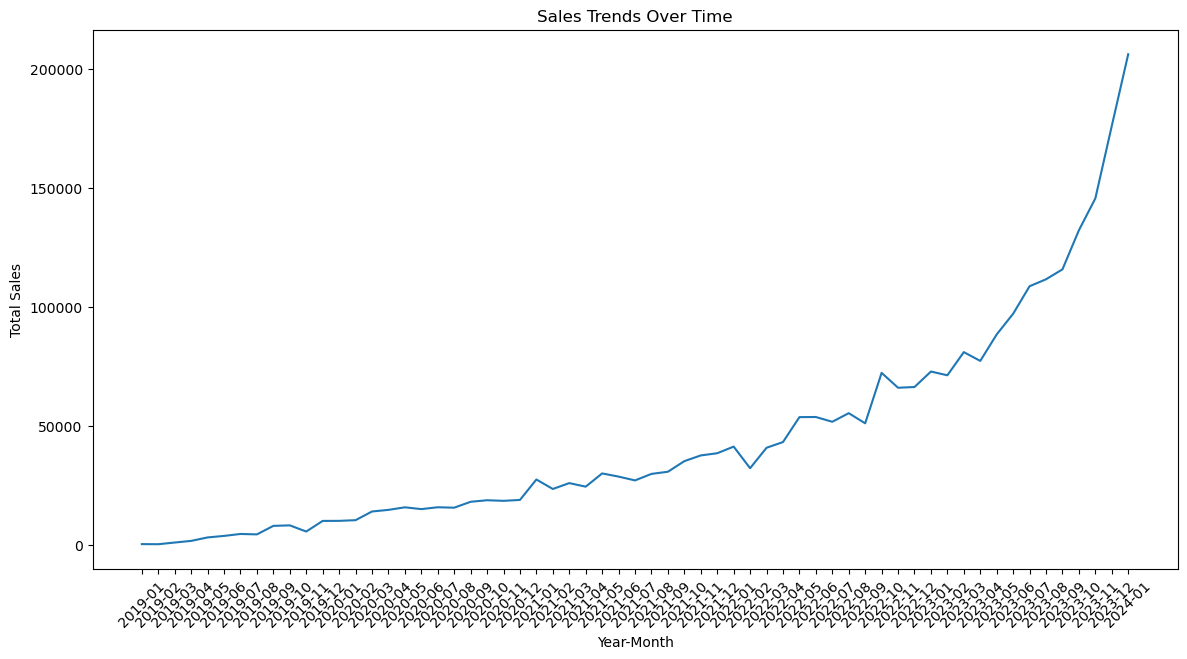

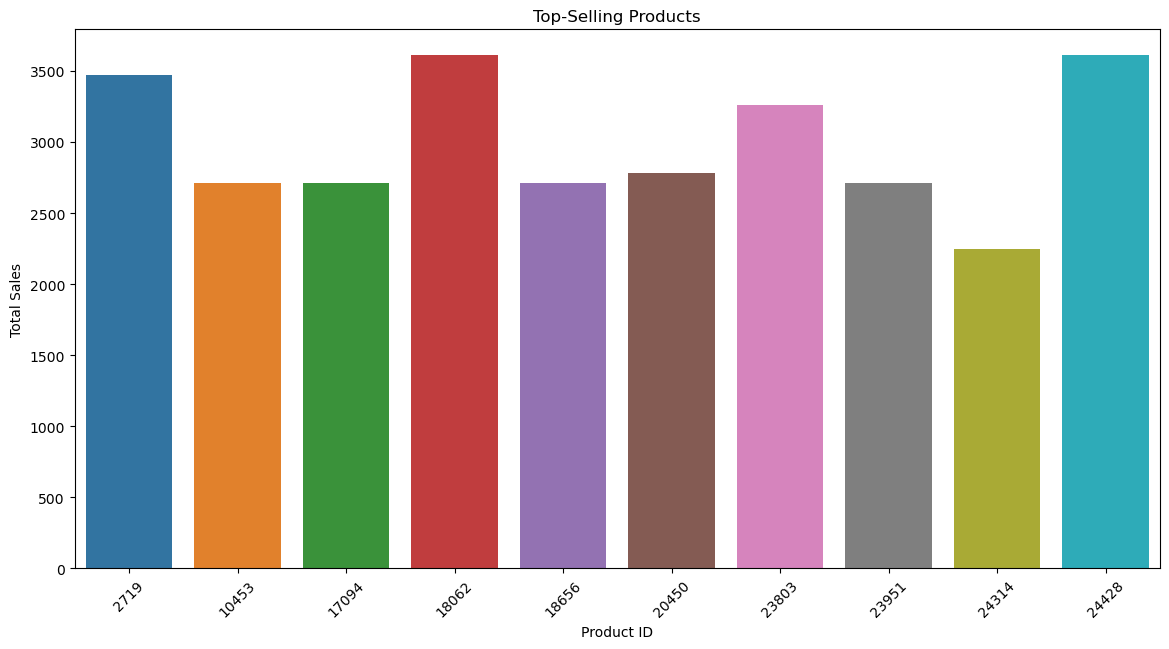

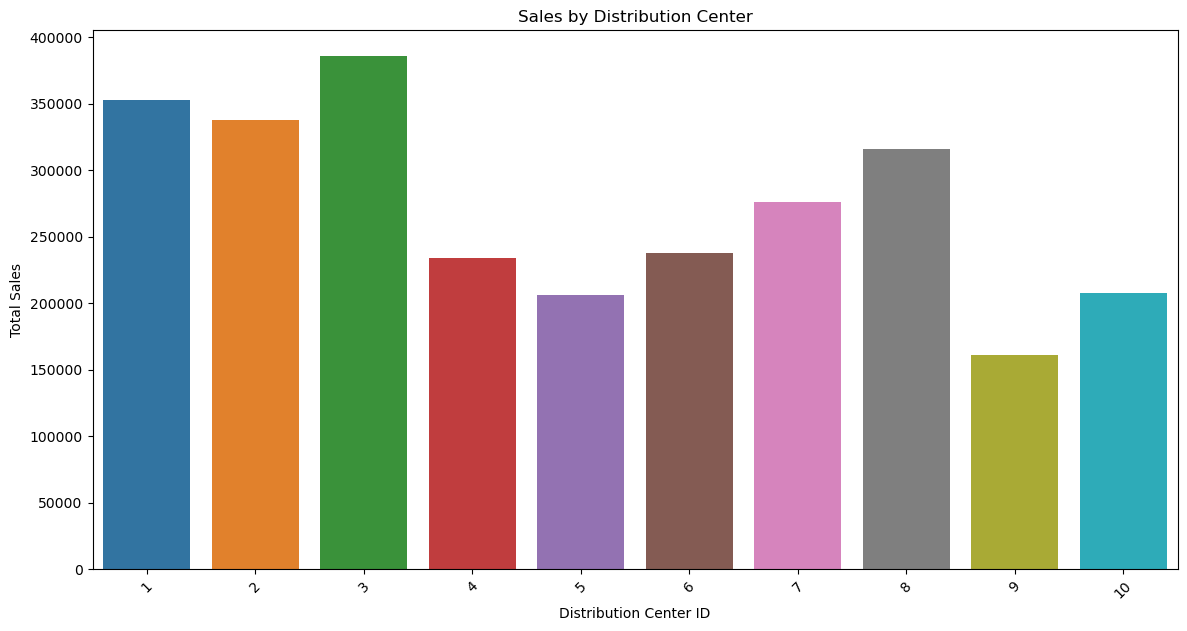

Columns in df_orders: Index(['order_id', 'user_id', 'status', 'gender', 'created_at', 'returned_at',
       'shipped_at', 'delivered_at', 'num_of_item'],
      dtype='object')
Columns in df_order_items: Index(['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
       'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price'],
      dtype='object')
Columns in df_users: Index(['id', 'first_name', 'last_name', 'email', 'age', 'gender', 'state',
       'street_address', 'postal_code', 'city', 'country', 'latitude',
       'longitude', 'traffic_source', 'created_at'],
      dtype='object')
Columns in orders_items_merged: Index(['order_id', 'user_id_x', 'status_x', 'gender', 'created_at_x',
       'returned_at_x', 'shipped_at_x', 'delivered_at_x', 'num_of_item', 'id',
       'user_id_y', 'product_id', 'inventory_item_id', 'status_y',
       'created_at_y', 'shipped_at_y', 'delivered_at_y', 'returned_at_y',
       'sale_price'],
      dtype='object'

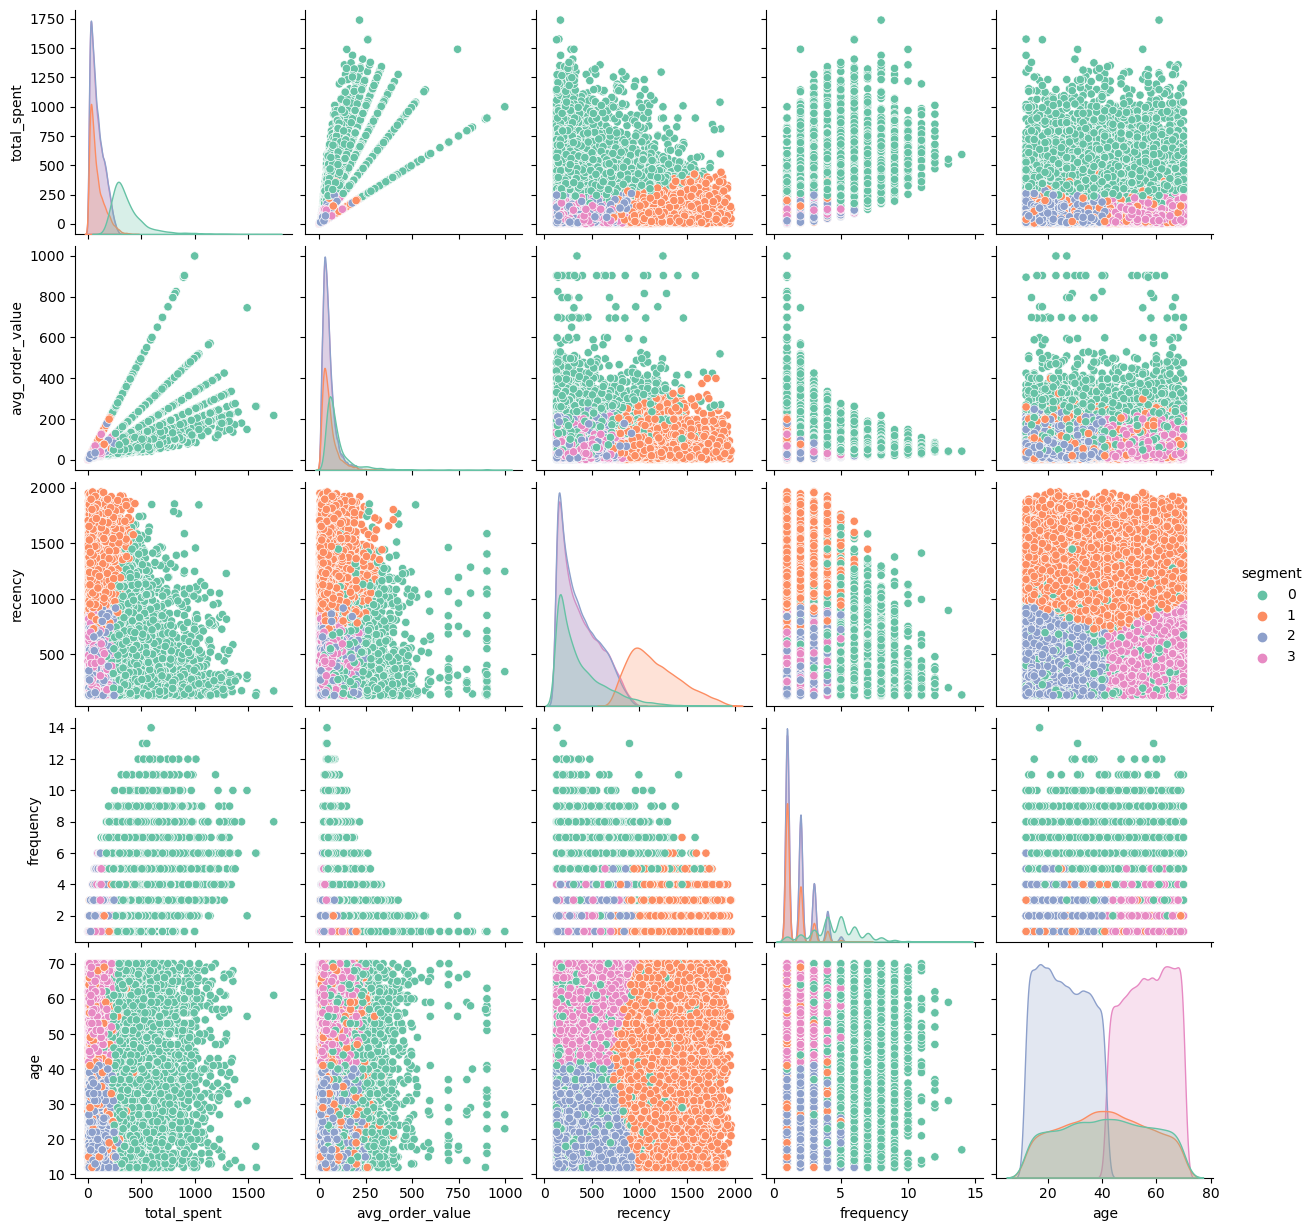

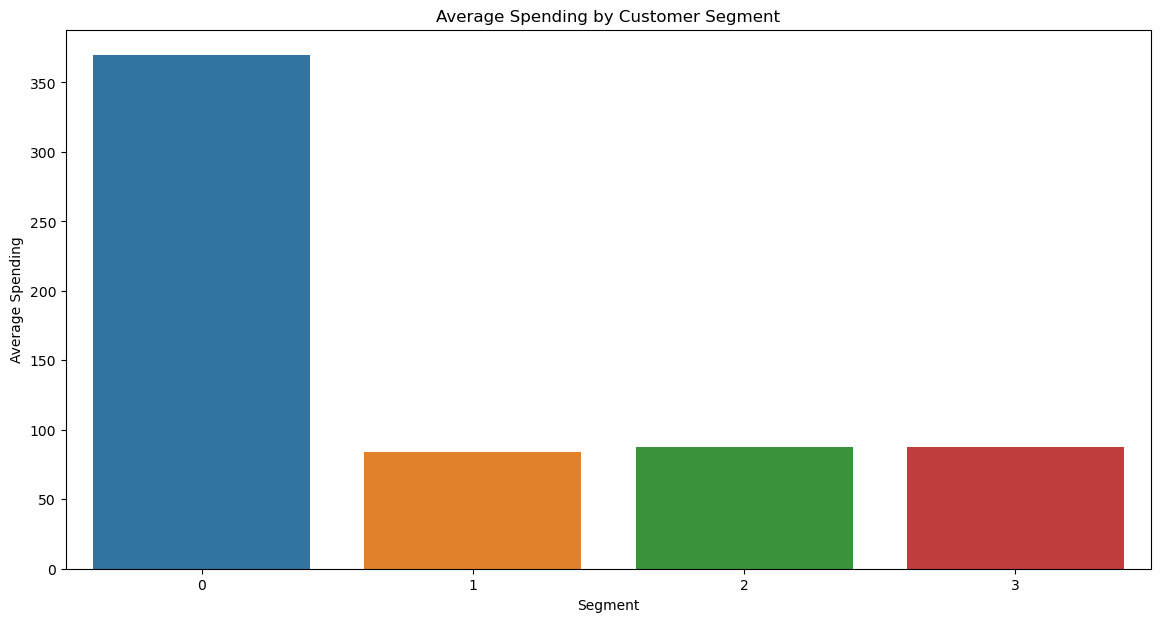

In [6]:
# Example usage
if __name__ == "__main__":
    base_dir = "C:/Users/Hande/Desktop/Data_Consulting/DataConsulting/Data"
    df_orders, df_order_items, df_products, df_distribution_centers, df_users = load_data(base_dir)
    orders_complete = transform_data(df_orders, df_order_items, df_products)
    analyze_sales_performance(orders_complete)
    customer_segmentation(df_orders, df_order_items, df_users)